<img src = 'https://upload.wikimedia.org/wikipedia/en/thumb/5/58/Reddit_logo_new.svg/375px-Reddit_logo_new.svg.png' />

Reddit is a collection of communities where users post content, comment, vote, and interact with other users. A single community is called a subreddit and Reddit is home to over 1.2 million subreddits with 330 million users. <a href='https://www.reddit.com/r/datascience/'>r/datascience</a> is a subreddit which was created as *'A place for data science practitioners and professionals to discuss and debate data science career questions.'* It currently has close to 146,000 members, and in this project, I aim to find the topics of discussion in this particular subreddit.

**The following notebook contains interactive pyLDAvis and plotly visualizations which are not rendered on GitHub. Please use the following link to view the notebook with rendered interactive visualizations - https://nbviewer.jupyter.org/github/ap1495/What-are-the-discussions-in-the-data-science-community-on-Reddit-/blob/master/RedditTopicModeling.ipynb**

# Problem Statement
What topics are being discussed in the <a href='https://www.reddit.com/r/datascience/'>r/datascience</a> subreddit? I intend to answer this question through Topic Modeling using Latent Dirichlet Allocation(LDA).

# Gathering Data
The data for this project will be all the posts on <a href='https://www.reddit.com/r/datascience/'>r/datascience</a> subreddit for the past two years from Sep 3rd, 2019. Collection of data was done through <a href='https://github.com/pushshift/api'>Pushshift</a> API which was created by the moderators of <a href='https://www.reddit.com/r/datasets/'>r/datasets</a>. The python script for the same can be found in the code folder.

# Data Preprocessing
Tokenization, stopwords removal, lemmatization etc. are some of the preprocessing techniques that have been used in this project to prepare the data for the LDA model.

# Topic Modeling & Visualizations
Interpreting the results of the LDA model and visualizing topics & terms using pyLDAvis and plotly.<br><br><br>

**Author: Abhishek Annappa Prabhu<br>
Email: aannappa@buffalo.edu**<br><br><br>
<br>

------------------------------

<br><br><br>

### Importing Libraries

In [1]:
#Import numpy and pandas to read and clean data.
import numpy as np
import pandas as pd

#Import gensim library to preprocess and build the topic model.
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel

#Import nltk stopwords and add custom stopwords that are likely to appear in reddit posts.
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['https', 'com', 'www', 'http', 'reddit', 'comment', 'message', 
                   'removed', 'thread', 'subreddit', 'link', 'post', 'commented',
                   'comments', 'deleted', 'messages', 'would', 'know', 'want', 'look'
                  ])

import spacy

#Import pyLDAvis to visualize results of LDA model.
import pyLDAvis
import pyLDAvis.gensim 

#Import plotly to create interactive visualizations.
import plotly.offline as py
import cufflinks as cf
from plotly.offline import download_plotlyjs, iplot, plot, init_notebook_mode
from plotly import tools
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt

#Import wordlcoud to generate a wordcloud
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

C:\Users\Abhishek\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


C:\Users\Abhishek\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:531: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




In [2]:
df = pd.read_csv('F:/DS/RedditScraping/datascience2.csv')

In [3]:
df.head()

,title,author,score,id,url,comms_num,created,body,timestamp
0,6 Techniques to Boost your Machine Learning Mo...,seemingly_omniscient,1,czb77k,https://www.aisoma.de/6-techniques-to-boost-yo...,0,1.567561e+09,NaN,2019-09-03 21:31:09
1,Facebook data scientist on-site tips,whatthehell2560,1,czaved,https://www.reddit.com/r/datascience/comments/...,2,1.567559e+09,[removed],2019-09-03 21:06:03
2,Can I get into Data Analysis with an MBA?,renny811,1,cz9uk7,https://www.reddit.com/r/datascience/comments/...,2,1.567555e+09,[removed],2019-09-03 19:49:51
3,Top skills required for entry level jobs in Da...,randomstudent2019,1,cz9gt4,https://www.reddit.com/r/datascience/comments/...,2,1.567553e+09,[https://apvidul.com/top-skills-data-science/]...,2019-09-03 19:21:09
4,SQL actual power in Data Science,Sabado-de-sol,1,cz9erw,https://www.reddit.com/r/datascience/comments/...,2,1.567553e+09,[removed],2019-09-03 19:17:06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21222 entries, 0 to 21221
Data columns (total 9 columns):
title        21222 non-null object
author       21222 non-null object
score        21222 non-null int64
id           21222 non-null object
url          21222 non-null object
comms_num    21222 non-null int64
created      21222 non-null float64
body         14536 non-null object
timestamp    21222 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 1.5+ MB


There are missing values in the column **body**. Let's replace this with an empty string. <br>
Occasionally, a few posts get taken down and the body of the post is replaced with **\[removed]**. This is again replaced with an empty string.

In [5]:
df['body'].fillna(value='', inplace=True)
df['body'].replace('[removed]', '', inplace=True)

### Data Preprocessing

In [6]:
#Creating new column 'text' that holds title and body of the post.
df['text'] = df['title'] + ' ' + df['body']

In [7]:
#Appending values of text column to a list.
data = df['text'].values.tolist()
print(data[0])

6 Techniques to Boost your Machine Learning Models 


In [8]:
#Tokenizing sentences into words.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
#Removes stopwords and words whose length is lesser than or equal to 3.
def remove_stopwords(docs):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words and len(word) > 3] for doc in docs]

#Write what lemmatization does
def lemmatization(docs, allowed_postags):
    texts_out = []
    for sent in docs:
        doc = nlp(' '.join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    return texts_out

In [9]:
data_words = list(sent_to_words(data))
print('After Tokenization:')
print(data_words[0], '\n\n')

data_words_nostops = remove_stopwords(data_words)
print('After removing stopwords:')
print(data_words_nostops[0], '\n\n')

#Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm')

#Performing lemmatization keeping only nouns, adjectives, verbs and adverbs
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
data_lemmatized = lemmatization(data_words_nostops, allowed_postags)
print('After lemmatization:')
print(data_lemmatized[0])

After Tokenization:
['techniques', 'to', 'boost', 'your', 'machine', 'learning', 'models'] 


After removing stopwords:
['techniques', 'boost', 'machine', 'learning', 'models'] 


After lemmatization:
['technique', 'boost', 'machine', 'learning', 'model']


In [10]:
#Creating a dictionary of words present in the dataset.
id2word = corpora.Dictionary(data_lemmatized)
print('A peek into the dictionary:\n')
count = 0
for index, word in id2word.iteritems():
    print(index, word)
    count += 1
    if count > 10:
        break

A peek into the dictionary:

0 boost
1 learning
2 machine
3 model
4 technique
5 data
6 facebook
7 scientist
8 site
9 tip
10 analysis


In [11]:
#Creating a bag-of-words corpus with term document frequencies.
docs = data_lemmatized
bow_corpus = [id2word.doc2bow(doc) for doc in docs]

print('A sample from BOW Corpus:\n')
sample = bow_corpus[90]
for i in range(len(sample)):
    print('Word', sample[i][0], ':', id2word[sample[i][0]], ' || Number of occurences:', sample[i][1])

A sample from BOW Corpus:

Word 11 : datum  || Number of occurences: 2
Word 66 : anyone  || Number of occurences: 1
Word 94 : idea  || Number of occurences: 1
Word 104 : make  || Number of occurences: 2
Word 123 : use  || Number of occurences: 1
Word 126 : visualization  || Number of occurences: 2
Word 133 : look  || Number of occurences: 1
Word 600 : report  || Number of occurences: 1
Word 621 : similar  || Number of occurences: 1
Word 622 : software  || Number of occurences: 1
Word 913 : one  || Number of occurences: 1
Word 933 : aroundtown  || Number of occurences: 1
Word 934 : attach  || Number of occurences: 1
Word 935 : download  || Number of occurences: 1
Word 936 : fileadmin  || Number of occurences: 1
Word 937 : page  || Number of occurences: 1
Word 938 : user_upload  || Number of occurences: 1


### Applying the LDA Model

In [12]:
lda_model = LdaModel(corpus=bow_corpus, id2word=id2word, num_topics=5, random_state=100, update_every=1, chunksize=100, 
                     passes=10, alpha='auto', per_word_topics=True)

In [13]:
for i, topic in lda_model.print_topics(-1):
    print('Topic:', i, '\n', 'Words:', topic, '\n')

Topic: 0 
 Words: 0.025*"datum" + 0.023*"use" + 0.011*"need" + 0.011*"problem" + 0.011*"analysis" + 0.010*"time" + 0.010*"help" + 0.009*"find" + 0.009*"build" + 0.009*"point" 

Topic: 1 
 Words: 0.055*"python" + 0.053*"machine" + 0.045*"learn" + 0.043*"learning" + 0.016*"list" + 0.014*"code" + 0.014*"visualization" + 0.011*"user" + 0.011*"tech" + 0.010*"panda" 

Topic: 2 
 Words: 0.075*"datum" + 0.042*"science" + 0.014*"course" + 0.014*"scientist" + 0.013*"learn" + 0.013*"work" + 0.012*"data" + 0.012*"year" + 0.011*"take" + 0.010*"analytic" 

Topic: 3 
 Words: 0.057*"model" + 0.023*"deep" + 0.018*"regression" + 0.017*"test" + 0.016*"series" + 0.016*"value" + 0.016*"predict" + 0.014*"variable" + 0.014*"algorithm" + 0.013*"feature" 

Topic: 4 
 Words: 0.024*"work" + 0.022*"question" + 0.017*"company" + 0.016*"people" + 0.015*"make" + 0.012*"think" + 0.012*"interview" + 0.011*"thing" + 0.010*"something" + 0.009*"team" 



### Intepreting the above results -

The above result displays the top 10 keywords that contribute to a topic. The keywords are displayed along with their weights and the weights display how important the keyword is to that particular topic.
- Topic 0: Keywords include problem, analysis, build etc. => **Topic = Problem Analysis**
- Topic 1: Keywords include python, machine learning, visualization, etc. => **Topic = Python/Machine Learning**
- Topic 2: Keywords include datum, science, course, learn, work, etc. => **Topic = Academics/Knowledge**
- Topic 3: Keywords include model, deep, regression, predict, algorithm etc. => **Topic = Machine Learning/Deep Learning Models**
- Topic 4: Keywords include question, company, people, interveiw etc. => **Topic = Jobs/Work Life**


### Scoring and Topic Selection

In [14]:
for i, row in enumerate(lda_model[bow_corpus]):
    row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
    print('Document:', docs[0] )
    for index, score in sorted(row, key=lambda tup: -1*tup[1]):
        print('\nScore:', score, '\t \nTopic:', lda_model.print_topic(index, 10))
    break

Document: ['technique', 'boost', 'machine', 'learning', 'model']

Score: 0.38781914 	 
Topic: 0.055*"python" + 0.053*"machine" + 0.045*"learn" + 0.043*"learning" + 0.016*"list" + 0.014*"code" + 0.014*"visualization" + 0.011*"user" + 0.011*"tech" + 0.010*"panda"

Score: 0.24094121 	 
Topic: 0.075*"datum" + 0.042*"science" + 0.014*"course" + 0.014*"scientist" + 0.013*"learn" + 0.013*"work" + 0.012*"data" + 0.012*"year" + 0.011*"take" + 0.010*"analytic"

Score: 0.1290317 	 
Topic: 0.057*"model" + 0.023*"deep" + 0.018*"regression" + 0.017*"test" + 0.016*"series" + 0.016*"value" + 0.016*"predict" + 0.014*"variable" + 0.014*"algorithm" + 0.013*"feature"

Score: 0.12850587 	 
Topic: 0.025*"datum" + 0.023*"use" + 0.011*"need" + 0.011*"problem" + 0.011*"analysis" + 0.010*"time" + 0.010*"help" + 0.009*"find" + 0.009*"build" + 0.009*"point"

Score: 0.11370206 	 
Topic: 0.024*"work" + 0.022*"question" + 0.017*"company" + 0.016*"people" + 0.015*"make" + 0.012*"think" + 0.012*"interview" + 0.011*"th

The above output shows scores of the first document in our corpus across different topics. Each document in the corpus is assigned scores pertaining to the 5 topics that the model has established. It makes sense to choose the topic with the highest score as the most relevant topic present in that document. 

### Assigning Topics

In [15]:
def get_topics(ldamodel, corpus, texts):
    '''
    Returns a dataframe with the original post, the topic associated with it, the topic contribution and the keywords.
    
    '''
    df_topics = pd.DataFrame()

    #Get the most relevant topic in each document.
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                df_topics = df_topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), 
                                                       ignore_index=True)
                
    df_topics.columns = ['Topic', 'TopicPercentageContribution', 'Keywords']

    #Adding a column with the original post content.
    contents = pd.Series(texts)
    df_topics = pd.concat([df_topics, contents], axis=1)
    df_topics.columns = ['Topic', 'TopicPercentageContribution', 'Keywords', 'OriginalPost']
    
    return df_topics

df_topics = get_topics(lda_model, bow_corpus, data)

### Replacing topic number with equivalent topic names.

In [16]:
pd.set_option('display.max_colwidth', -1)

indices = []
for i in df_topics['Topic'].unique():
    indices.append(df_topics[df_topics['Topic'] == i]
                   .sample(random_state=1000).index.values[0])
    
topic_names = ['Problem Analysis', 'Python/Machine Learning', 'Academics/Knowledge', 
               'Machine Learning/Deep Learning Models', 'Jobs/Work Life']

df_topics['Topic'] = df_topics['Topic'].apply(lambda x: topic_names[int(x)])


df_topics.loc[indices][['OriginalPost', 'Topic']]

,OriginalPost,Topic
16094,Using Machine Learning to estimate discriminations in France,Python/Machine Learning
9524,"Anyone have experience doing data science/analyst work in China/Asia? Hi folks,\n\nI’ve been interested in working abroad for several years and I’m wondering what job prospects for data analyst / data scientists are for foreigners in China / Asia region are. What is the salary like compared to jobs in the U.S and Europe? How is upward mobility and working environment like? Are there any differences in responsibilities or expectations? What are the typical educational requirements for entry/mid-level employment? Any input on this is greatly appreciated.\n\nThanks in advance!",Academics/Knowledge
19644,Analyzing 1000+ Greek Wines With Python,Problem Analysis
18526,"Are linear regression algorithms essentially just doing extrapolation? Hi, I am new to Data Science and i was wondering if anyone can explain to me what a linear regression algorithm is and how one would implemented into data mining.",Machine Learning/Deep Learning Models
14517,What's the dumbest thing a manager or executive ever said or asked you to do?,Jobs/Work Life


### Visualizing topics-keywords using pyLDAvis' interactive visualization

In [17]:
pd.set_option('display.max_colwidth', 60)
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word, sort_topics=False)
pyLDAvis.display(vis)

- **Topic 1: Problem Analysis || Topic 2: Python/Machine Learning || Topic 3: Academics/Knowledge || Topic 4: Machine Learning/Deep Learning Models || Topic 5: Jobs/Work Life**
- Bubbles on the left hand side of the plot represent a topic. Larger the bubble, more prevalent is the topic.
- A good topic model is considered to have fairly large non overlapping bubbles scattered throughout the chart.<br>
The topic model built in this project has overlapping bubbles for topic 3 and topic 5 which are Academics/Knowledge and Jobs/Work Life respectively.
- Hover over the bubbles on the left to view the top 30 salient terms for that particular topic.
- Hover over the words on the right to view the topics they belong to.

In [18]:
#Creating two new features for our visualizations.
df_topics['Month'] = df['timestamp'].apply(lambda x: x[5:7])
df_topics['Year'] = df['timestamp'].apply(lambda x: x[0:4])

### Distribution of Topics

In [19]:
trace1 = go.Bar(x=df_topics['Topic'].value_counts().sort_values(ascending=True).values,
                y=df_topics['Topic'].value_counts().sort_values(ascending=True).index.values,
                orientation='h',
                opacity=0.9
               )

layout = go.Layout(title='<b>Topics by Count </b>',
                   xaxis=dict(title='Count'),
                   yaxis=dict(title='Topics',
                              automargin=True
                             ))

fig = go.Figure(data=[trace1], layout=layout)
py.iplot(fig)

- **Academics/Knowledge** is the number 1 topic with 14,266 posts in a span of 2 years.
- Hover over the viz to get the exact count of the topics.

### Number of posts across topics month-wise

For this visualization, I have taken into account the number of posts across different topics for the year 2018. For the years 2017 and 2019, the dataset does not contain data for all the months, hence I will use the year 2018.

In [20]:
traces = []
months = np.sort(df_topics['Month'].unique()).tolist()
topics = df_topics['Topic'].unique().tolist()

for topic in topics:
    y=df_topics[(df_topics['Year'] == '2018') & (df_topics['Topic'] == topic)].groupby(by='Month')['Topic'].count().values.tolist()
    traces.append(go.Scatter(x=months,
                             y=y,
                             name=topic
                            )
                )

layout = go.Layout(title='<b>Month-wise breakdown of number of posts in 2018</b>',
                   yaxis=dict(title='Number of Posts'),
                   xaxis=dict(title='Month'))

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)

- Hover over the viz to get moe information. Also, enable/disable different topics using the legend in the top right corner.

### Wordcloud of all the posts.

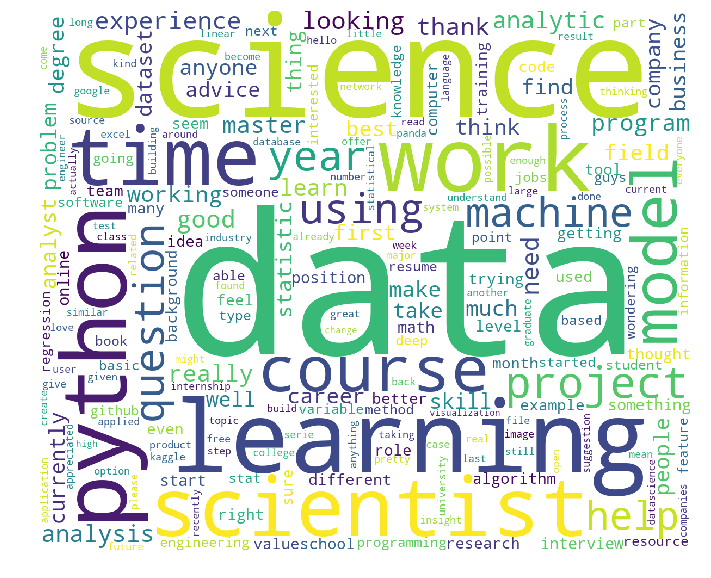

In [21]:
norm_text = ''
for data in data_words_nostops:
    norm_text += ' '.join(data)
    norm_text += ' '

text = norm_text

wordcloud = WordCloud(background_color='white', collocations=False,
                      width=1200, height=1000, random_state=81, colormap='viridis').generate(text)

plt.figure(figsize=(12,10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()